# Constraint Satisfaction Problems Lab

## Introduction
Constraint Satisfaction is a technique for solving problems by expressing limits on the values of each variable in the solution with mathematical constraints.  We've used constraints before -- constraints in the Sudoku project are enforced implicitly by filtering the legal values for each box, and the planning project represents constraints as arcs connecting nodes in the planning graph -- but in this lab exercise we will use a symbolic math library to explicitly construct binary constraints and then use Backtracking to solve the N-queens problem (which is a generalization [8-queens problem](https://en.wikipedia.org/wiki/Eight_queens_puzzle)).  Using symbolic constraints should make it easier to visualize and reason about the constraints (especially for debugging), but comes with a performance penalty.

![8-queens puzzle solution](EightQueens.gif)

Briefly, the 8-queens problem asks you to place 8 queens on a standard 8x8 chessboard such that none of the queens are in "check" (i.e., no two queens occupy the same row, column, or diagonal). The N-queens problem generalizes the puzzle to to any size square board.

## I. Lab Overview
Students should read through the code and the wikipedia page (or other resources) to understand the N-queens problem, then:

0. Complete the warmup exercises in the [Sympy_Intro notebook](Sympy_Intro.ipynb) to become familiar with they sympy library and symbolic representation for constraints
0. Implement the [NQueensCSP class](#II.-Representing-the-N-Queens-Problem) to develop an efficient encoding of the N-queens problem and explicitly generate the constraints bounding the solution
0. Write the [search functions](#III.-Backtracking-Search) for recursive backtracking, and use them to solve the N-queens problem
0. (Optional) Conduct [additional experiments](#IV.-Experiments-%28Optional%29) with CSPs and various modifications to the search order (minimum remaining values, least constraining value, etc.)

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from util import constraint, displayBoard
from sympy import *
from IPython.display import display
init_printing()
%matplotlib inline

In [2]:
from functools import reduce
def count_if(predicate, seq):
    """Count the number of elements of seq for which the predicate is true.
    """
    f = lambda count, x: count + (not not predicate(x))
    return reduce(f, seq, 0)

def every(predicate, seq):
    """True if every element of seq satisfies predicate.
    """
    for x in seq:
        if not predicate(x): return False
    return True

## II. Representing the N-Queens Problem
There are many acceptable ways to represent the N-queens problem, but one convenient way is to recognize that one of the constraints (either the row or column constraint) can be enforced implicitly by the encoding.  If we represent a solution as an array with N elements, then each position in the array can represent a column of the board, and the value at each position can represent which row the queen is placed on.

In this encoding, we only need a constraint to make sure that no two queens occupy the same row, and one to make sure that no two queens occupy the same diagonal.

### Define Symbolic Expressions for the Problem Constraints
Before implementing the board class, we need to construct the symbolic constraints that will be used in the CSP.  Declare any symbolic terms required, and then declare two generic constraint generators:
- `diffRow` - generate constraints that return True if the two arguments do not match
- `diffDiag` - generate constraints that return True if two arguments are not on the same diagonal (Hint: you can easily test whether queens in two columns are on the same diagonal by testing if the difference in the number of rows and the number of columns match)

Both generators should produce binary constraints (i.e., each should have two free symbols) once they're bound to specific variables in the CSP.  For example, Eq((a + b), (b + c)) is not a binary constraint, but Eq((a + b), (b + c)).subs(b, 1) _is_ a binary constraint because one of the terms has been bound to a constant, so there are only two free variables remaining. 

In [3]:
# Declare any required symbolic variables
C = symbols('C:2') # X = (column_1, column_2) # the columns that are compared
R = symbols('Y:2') # Y = (row_1, row_2) # the values of the columns that are compared

# Define diffRow and diffDiag constraints
diffRow  = constraint('different Rows', Ne(R[0], R[1]))
diffDiag = constraint("different Diagonals", Ne(Abs(C[0] - C[1]), Abs(R[0] - R[1])))
# taking absolute values to take acount both left and right diagonals or going up and down

In [4]:
# Test diffRow and diffDiag
_x = symbols("x:3")

# generate a diffRow instance for testing
diffRow_test = diffRow.subs({ R[0]: _x[0], R[1]: _x[1]})

assert(len(diffRow_test.free_symbols) == 2)
assert(diffRow_test.subs({_x[0]: 0, _x[1]: 1}) == True)
assert(diffRow_test.subs({_x[0]: 0, _x[1]: 0}) == False)
assert(diffRow_test.subs({_x[0]: 0}) != False)  # partial assignment is not false
print("Passed all diffRow tests.")

# generate a diffDiag instance for testing
diffDiag_test = diffDiag.subs({C[0]: 0, C[1]: 2, R[0]:_x[0], R[1]:_x[2]})

assert(len(diffDiag_test.free_symbols) == 2)
assert(diffDiag_test.subs({_x[0]: 0, _x[2]: 2}) == False)
assert(diffDiag_test.subs({_x[0]: 0, _x[2]: 0}) == True)
assert(diffDiag_test.subs({_x[0]: 0}) != False)  # partial assignment is not false
print("Passed all diffDiag tests.")

Passed all diffRow tests.
Passed all diffDiag tests.


### The N-Queens CSP Class
Implement the CSP class as described above, with constraints to make sure each queen is on a different row and different diagonal than every other queen, and a variable for each column defining the row that containing a queen in that column.

In [55]:
class NQueensCSP:
    """CSP representation of the N-queens problem
    
    Parameters
    ----------
    N : Integer
        The side length of a square chess board to use for the problem, and
        the number of queens that must be placed on the board
    """
    def __init__(self, N, createConstrains=True):
        _vars = symbols('q:{}'.format(N)) # q0:qN . q for queen
        _domain = set(range(N)) # the posible values each variable can get
        self.size = N
        self.variables = _vars
        self.domains = {v: _domain for v in _vars}
        self._constraints = {x: set() for x in _vars}
        self.use_forward_check = False
        self.use_arc_consistency = False
        self.select_most_constrained = False
        self.order_by_least_constrained_value = False
        self.current_assignment = {}

        # add constraints - for each pair of variables xi and xj, create
        # a diffRow(xi, xj) and a diffDiag(xi, xj) instance, and add them
        # to the self._constraints dictionary keyed to both xi and xj;
        # (i.e., add them to both self._constraints[xi] and self._constraints[xj])
        if createConstrains:
            for i, queen_1 in enumerate(_vars[:-1]):
                for queen_2 in _vars[i+1:]:
                    # finding rows and columns for each of the columns in the problem
                    column_1, column_2 = _vars.index(queen_1), _vars.index(queen_2)
                    row_1, row_2 = queen_1, queen_2
                    # creating the substritution dictionary
                    subs_dict = {C[0]: column_1, C[1]: column_2, R[0]: row_1, R[1]: row_2}
                    # creating the constraints
                    rowConstraint = diffRow.subs(subs_dict)
                    diagonalConstraint = diffDiag.subs(subs_dict)
                    # applying the constraints to both queens
                    self._constraints[queen_1].add(rowConstraint)
                    self._constraints[queen_2].add(rowConstraint)
                    self._constraints[queen_1].add(diagonalConstraint)
                    self._constraints[queen_2].add(diagonalConstraint)
                
    def deepcopy(self):
        newQueensCSP = NQueensCSP(self.size, createConstrains=False)
        newQueensCSP.domains = {v: self.domains[v].copy() for v in newQueensCSP.variables}
        newQueensCSP._constraints = self._constraints
        newQueensCSP.use_forward_check = self.use_forward_check
        newQueensCSP.use_arc_consistency = self.use_arc_consistency
        newQueensCSP.select_most_constrained = self.select_most_constrained
        newQueensCSP.order_by_least_constrained_value = self.order_by_least_constrained_value
        newQueensCSP.current_assignment = self.current_assignment.copy()
        return newQueensCSP
    
    @property
    def constraints(self):
        """Read-only list of constraints -- cannot be used for evaluation """
        constraints = set()
        for _cons in self._constraints.values():
            constraints |= _cons
        return list(constraints)
    
    
    def neighbors(self, variable):
        return [v for v in self.variables if v!=variable]
    
    
    def is_complete(self, assignment):
        """An assignment is complete if it is consistent, and all constraints
        are satisfied.
        
        Hint: Backtracking search checks consistency of each assignment, so checking
        for completeness can be done very efficiently
        
        Parameters
        ----------
        assignment : dict(sympy.Symbol: Integer)
            An assignment of values to variables that have previously been checked
            for consistency with the CSP constraints
        """
        # no need to check for consistency
        if len(assignment.items()) != self.size:
            return False
        return True
    
    def nconflicts(self, var, value, assignment):
        """Counts the number of conlicts var=value will cause"""
        def conflicts_with(var2):
            val2 = assignment.get(var2, None)
            return val2 != None and not self.is_consistent(var, value, {var2: val2})
        return count_if(conflicts_with, self.variables)
    
    
    def are_consistent(self, var1, val1, var2, val2):
        """Binary constraint check between two variable"""
        return self.is_consistent(var1, val1, {var2: val2})
    

    def is_consistent(self, var, value, assignment):
        """Check consistency of a proposed variable assignment
                
        self._constraints[x] returns a set of constraints that involve variable `x`.
        An assignment is consistent unless the assignment it causes a constraint to
        return False (partial assignments are always consistent).
        
        Parameters
        ----------
        var : sympy.Symbol
            One of the symbolic variables in the CSP
            
        value : Numeric
            A valid value (i.e., in the domain of) the variable `var` for assignment

        assignment : dict(sympy.Symbol: Integer)
            A dictionary mapping CSP variables to row assignment of each queen
            
        """
        consistent = True
        updated_assignments = dict(assignment)
        updated_assignments.update({var: value}) # new dictionary with the new assignment included
        
        for constraint in self._constraints[var]: # for all the variable constraints
            # evaluate using the updated dictionary
            constraint_eval = constraint.subs(updated_assignments)
            if len(constraint_eval.free_symbols) == 0:
                consistent &= constraint_eval
                
        return consistent
    
    def forward_check(self, var, value, assignment):
        """Forward checking (domain reduction). It will prune the domain values
        This is why we create a copy of the board to pass at the next step to avoid
        bookeeping of the domains. This is not memory efficient. To avoid that we can create
        a function to undo domain pruning
        """       
        not_assigned_variables = [v for v in self.neighbors(var) if not assignment.get(v, None)]
        for var_2 in not_assigned_variables:
            new_domain = self.domains[var_2].copy() # cannot remove from set during iteration so create a copy
            for value_2 in self.domains[var_2]: # for all variables that are allowed
                if not self.are_consistent(var, value, var_2, value_2): # if the values for var_2 are not consistent
                    new_domain.remove(value_2) # we remove them from the available in domain
            self.domains[var_2] = new_domain
            
    def remove_inconsistent_values(self, var_x, var_y):
        """Returns true if a value is removed"""
        removed = False
        newDomainForX = self.domains[var_x].copy()
        for x in self.domains[var_x]:
            if every(lambda y: not self.are_consistent(var_x, x, var_y, y), self.domains[var_y]):
                # if varX=x conflicts with every value y for varY, remove x 
                newDomainForX.remove(x)
                removed = True
        if removed:
            self.domains[var_x] = newDomainForX
        return removed
    
    def arc_consistency_check(self, queue=None):
        if queue == None:
            queue = [(X, Y) for X in self.variables for Y in self.neighbors(X)]
            # X is tail Y is front. always delete from tail
        while queue:
            X, Y = queue.pop()
            if self.remove_inconsistent_values(X, Y): # add back with X front
                for Z in self.neighbors(X):
                    queue.append((Z, X))
        
        
    def inference(self, var, value):
        """Perform logical inference based on proposed variable assignment
        
        Returns an empty dictionary by default; function can be overridden to
        check arc-, path-, or k-consistency; returning None signals "failure".
        
        Parameters
        ----------
        var : sympy.Symbol
            One of the symbolic variables in the CSP
        
        value : Integer
            A valid value (i.e., in the domain of) the variable `var` for assignment
            
        Returns
        -------
        dict(sympy.Symbol: Integer) or None
            A partial set of values mapped to variables in the CSP based on inferred
            constraints from previous mappings, or None to indicate failure
        """
        # TODO (Optional): Implement this function based on AIMA discussion
        return {}
    
    def show(self, assignment):
        """Display a chessboard with queens drawn in the locations specified by an
        assignment
        
        Parameters
        ----------
        assignment : dict(sympy.Symbol: Integer)
            A dictionary mapping CSP variables to row assignment of each queen
            
        """
        print("Assignment",assignment)
        locations = [(i, assignment[j]) for i, j in enumerate(self.variables)
                     if assignment.get(j, None) is not None]
        displayBoard(locations, self.size)

### Testing N-Queens CSP Class

Assignment {q0: 2, q1: 0, q2: 3, q3: 1}


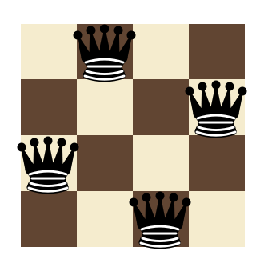

In [56]:
import numpy.random as random

num_queens = 4
queen_test = NQueensCSP(num_queens)
variables_test = queen_test.variables
random_queen = queen_test.variables[random.choice(num_queens)]
first_column_queen = queen_test.variables[0]
second_column_queen = queen_test.variables[1]
copyCSP = queen_test.deepcopy()

solution_test = {    
    queen_test.variables[0]: 2,
    queen_test.variables[1]: 0,
    queen_test.variables[2]: 3,
    queen_test.variables[3]: 1}

no_solution_test = {
    queen_test.variables[0]: 0,
    queen_test.variables[1]: 1,
    queen_test.variables[2]: 3,
    queen_test.variables[3]: 0}

queen_test.show(solution_test) # test show is working

assert(queen_test.nconflicts(first_column_queen, 0, no_solution_test) == 2) # number of conflict count
assert(len(queen_test.variables) == num_queens)
assert(queen_test.domains[random_queen] == {0, 1, 2, 3}) # correct domain
assert(len(queen_test._constraints[random_queen]) == (num_queens - 1) * 2) # correct number of constrains
# completness checks
assert(queen_test.is_complete({}) == False)
assert(queen_test.is_complete({random_queen: 1}) == False)
assert(queen_test.is_complete(solution_test) == True)
# consistency checks
assert(queen_test.is_consistent(random_queen, 0, {}) == True)
assert(queen_test.is_consistent(first_column_queen, 0, {second_column_queen: 0}) == False) # row violation
assert(queen_test.is_consistent(first_column_queen, 0, {second_column_queen: 1}) == False) # diagonal violation
assert(queen_test.is_consistent(first_column_queen, 0, {second_column_queen: 2}) == True) # no violation
# deepcopy works
assert(queen_test.domains == copyCSP.domains)

# forward checking
queen_test.forward_check(first_column_queen, 0, {})
assert(queen_test.domains[queen_test.variables[1]] == {2,3})
assert(queen_test.domains[queen_test.variables[2]] == {1,3})
assert(queen_test.domains[queen_test.variables[3]] == {1,2})

## III. Backtracking Search
Implement the [backtracking search](https://github.com/aimacode/aima-pseudocode/blob/master/md/Backtracking-Search.md) algorithm (required) and helper functions (optional) from the AIMA text.  

In [57]:
def select_naive(csp, assignment): # First unassigned variable
    for var in csp.variables:
        if var not in assignment:
            return var
    return None

def select_most_constrained_variable(csp, assignment): # Most Constrained Variable
    from collections import defaultdict

    unassigned = [v for v in csp.variables if v not in assignment]
    domainSizes = defaultdict(list)
    for v in unassigned:
        domainSizes[len(csp.domains[v])].append(v)
    smallerSize = min(domainSizes.keys()) # the smallest entry in the dictionary
    return domainSizes[smallerSize][0]  # the first element from the list of variables with that size

def order_naive(var, assignment, csp):
    return csp.domains[var]

def order_less_constrained_value(var, assignment, csp):
    # values with fewer conflicts
    key = lambda value: csp.nconflicts(var, value, assignment)
    return sorted(csp.domains[var], key=key)
    

In [58]:
def select(csp, assignment):
    """Choose an unassigned variable in a constraint satisfaction problem """
    # TODO (Optional): Implement a more sophisticated selection routine from AIMA
    if csp.select_most_constrained:
        return select_most_constrained_variable(csp, assignment)
    else:
        return select_naive(csp, assignment)


def order_values(var, assignment, csp):
    """Select the order of the values in the domain of a variable for checking during search;
    the default is lexicographically.
    """
    # TODO (Optional): Implement a more sophisticated search ordering routine from AIMA
    if csp.order_by_least_constrained_value:
        return order_less_constrained_value(var, assignment, csp)
    else:
        return order_naive(var, assignment, csp)

def backtracking_search(csp):
    """Helper function used to initiate backtracking search """
    return backtrack({}, csp)

def backtrack(assignment, csp):
    """Perform backtracking search for a valid assignment to a CSP
    
    Parameters
    ----------
    assignment : dict(sympy.Symbol: Integer)
        An partial set of values mapped to variables in the CSP
        
    csp : CSP
        A problem encoded as a CSP. Interface should include csp.variables, csp.domains,
        csp.inference(), csp.is_consistent(), and csp.is_complete().
    
    Returns
    -------
    dict(sympy.Symbol: Integer) or None
        A partial set of values mapped to variables in the CSP, or None to indicate failure
    """
    if csp.is_complete(assignment):
        return assignment
    
    newQueen = select(csp, assignment)
    for value in order_values(newQueen, assignment, csp):
        # print('before check for column {} select value {}'.format(csp.variables.index(newQueen), value))
        # print('assignment is: ', assignment)
        if csp.is_consistent(newQueen, value, assignment):
            # print('for column {} select value {}'.format(csp.variables.index(newQueen), value))
            assignment[newQueen] = value
            newBoard = csp.deepcopy() # needed when doing inference to keep track of domain restrictions
            
            # prune with forward check
            if newBoard.use_forward_check: 
                newBoard.forward_check(newQueen, value, assignment)
            if newBoard.use_arc_consistency and len([v for v in csp.variables if v not in assignment])<0.1*csp.size:
                newBoard.arc_consistency_check([(X, newQueen) for X in newBoard.neighbors(newQueen)])
            result = backtrack(assignment, newBoard)
            # print('result: {} for assignment {}'.format(result, assignment))
            if result != None:
                return result # else next value in the loop
            del assignment[newQueen] # delete from the assignments the Queen
            

### Solve the CSP
With backtracking implemented, now you can use it to solve instances of the problem. We've started with the classical 8-queen version, but you can try other sizes as well.  Boards larger than 12x12 may take some time to solve because sympy is slow in the way its being used here, and because the selection and value ordering methods haven't been implemented.  See if you can implement any of the techniques in the AIMA text to speed up the solver!

In [90]:
num_queens = 16
csp = NQueensCSP(num_queens)
csp.use_forward_check = True
csp.use_arc_consistency = True
csp.select_most_constrained = True
csp.order_by_less_constrained_value = True

In [67]:
var = csp.variables[0]
print("CSP problems have variables, each variable has a domain, and the problem has a list of constraints.")
print("Showing the variables for the N-Queens CSP:")
display(csp.variables)
print("Showing domain for {}:".format(var))
display(csp.domains[var])
#print("And showing the constraints for {}:".format(var))
#display(csp._constraints[var])

CSP problems have variables, each variable has a domain, and the problem has a list of constraints.
Showing the variables for the N-Queens CSP:


Showing domain for q0:


Solving N-Queens CSP...
Finished in 3.7197132110595703 sec
Assignment {q0: 0, q1: 4, q2: 7, q3: 5, q6: 1, q4: 2, q5: 6, q7: 3}


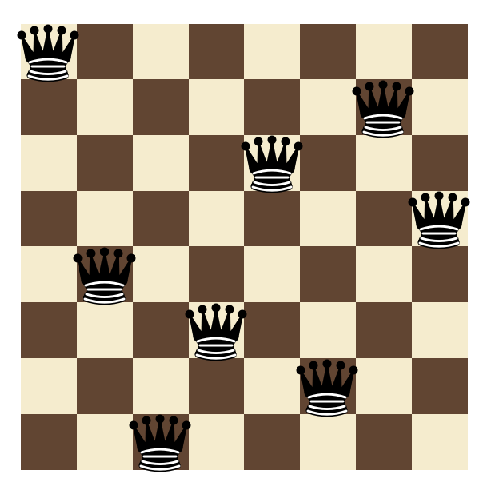

Solution found:
{q0: 0, q1: 4, q2: 7, q3: 5, q6: 1, q4: 2, q5: 6, q7: 3}


In [68]:
print("Solving N-Queens CSP...")

import time
timestart = time.time()
assn = backtracking_search(csp)
timeend = time.time()
print("Finished in {} sec".format(timeend-timestart))
if assn is not None:
    csp.show(assn)
    print("Solution found:\n{!s}".format(assn))
else:
    print("No solution found.")

## IV. Experiments (Optional)
For each optional experiment, discuss the answers to these questions on the forum: Do you expect this change to be more efficient, less efficient, or the same?  Why or why not?  Is your prediction correct?  What metric did you compare (e.g., time, space, nodes visited, etc.)?

- Implement a _bad_ N-queens solver: generate & test candidate solutions one at a time until a valid solution is found.  For example, represent the board as an array with $N^2$ elements, and let each element be True if there is a queen in that box, and False if it is empty.  Use an $N^2$-bit counter to generate solutions, then write a function to check if each solution is valid.  Notice that this solution doesn't require any of the techniques we've applied to other problems -- there is no DFS or backtracking, nor constraint propagation, or even explicitly defined variables.
- Use more complex constraints -- i.e., generalize the binary constraint RowDiff to an N-ary constraint AllRowsDiff, etc., -- and solve the problem again.
- Rewrite the CSP class to use forward checking to restrict the domain of each variable as new values are assigned.
- The sympy library isn't very fast, so this version of the CSP doesn't work well on boards bigger than about 12x12.  Write a new representation of the problem class that uses constraint functions (like the Sudoku project) to implicitly track constraint satisfaction through the restricted domain of each variable.  How much larger can you solve?
- Create your own CSP!

In [91]:
# Min-conflicts hillclimbing search for CSPs (from AIMA)

def min_conflicts(csp, max_steps=1000000):
    """Solve a CSP by stochastic hillclimbing on the number of conflicts."""
    # Generate a complete assignement for all vars (probably with conflicts)
    current = {}; csp.current_assignment = current
    # initialize variables
    for var in csp.variables:
        val = min_conflicts_value(csp, var)
        csp.current_assignment[var] = val
    # Now repeapedly choose a random conflicted variable and change it
    for i in range(max_steps):
        conflicted = variables_in_conflict(csp)
        # print(conflicted)
        if not conflicted: # found solution
            return csp.current_assignment
        var = random.choice(conflicted)
        val = min_conflicts_value(csp, var)
        csp.current_assignment[var] = val
    return None

def min_conflicts_value(csp, var):
    """Return the value that will give var the least number of conflicts.
    If there is a tie, choose at random."""
    fn = lambda value: csp.nconflicts(var, value, csp.current_assignment)
    seq = list(csp.domains[var])
    best_score = fn(seq[0])
    best_x = []
    for x in seq:
        x_score = fn(x)
        if x_score < best_score:
            best_x, best_score = [x], x_score
        elif x_score == best_score:
            best_x.append(x)
    return random.choice(best_x)

def variables_in_conflict(csp):
    return [var for var in csp.variables 
            if csp.nconflicts(var, csp.current_assignment[var], csp.current_assignment) > 0]

Finished in 56.233609676361084 sec
Assignment {q0: 10, q1: 8, q2: 11, q3: 5, q4: 2, q5: 9, q6: 6, q7: 0, q8: 13, q9: 15, q10: 1, q11: 14, q12: 4, q13: 7, q14: 3, q15: 12}


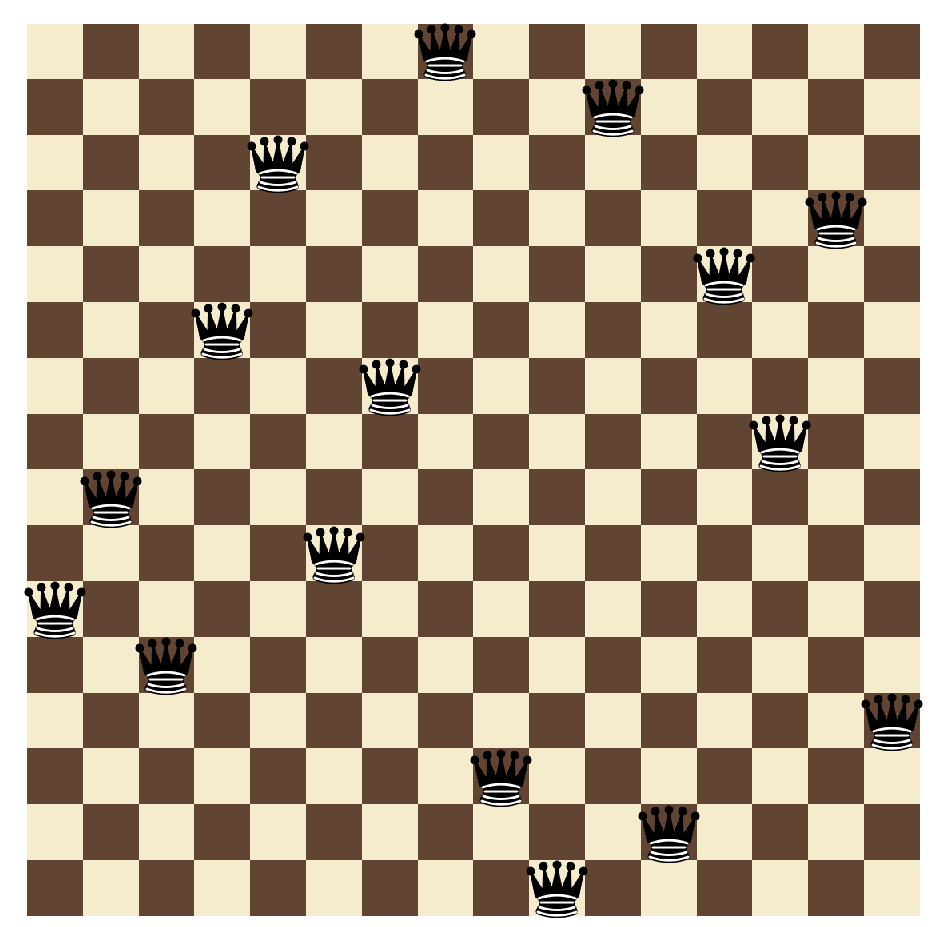

Solution found:
{q0: 10, q1: 8, q2: 11, q3: 5, q4: 2, q5: 9, q6: 6, q7: 0, q8: 13, q9: 15, q10: 1, q11: 14, q12: 4, q13: 7, q14: 3, q15: 12}


In [92]:
timestart = time.time()
solution = min_conflicts(csp)
timeend = time.time()
print("Finished in {} sec".format(timeend-timestart))
if solution is not None:
    csp.show(solution)
    print("Solution found:\n{!s}".format(solution))
else:
    print("No solution found.")